<a href="https://colab.research.google.com/github/KDOXG/Inteligencia-Artificial/blob/master/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST Multilayer Perceptron**


<img src="https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png" width="250" />

[Dataset link](http://yann.lecun.com/exdb/mnist/)

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [0]:
print(torch.__version__)

1.3.0+cu100


In [0]:
BATCH_SIZE = 32

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


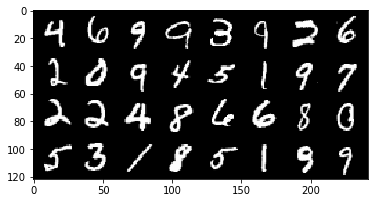

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [0]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
        self.activation_function = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        x = F.softmax(x, dim=1)
        return x

In [0]:
model = MLP()
for images, labels in train_loader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [0]:
model = MLP()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (activation_function): ReLU()
)


In [0]:
learning_rate = 0.001
num_epochs = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
train_losses = []
running_losses_list = []
train_accuracy_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    accuracy = 0.0
    total = 0
    correct = 0

    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    model.eval()
    accuracy = correct / total
    train_accuracy_list.append(accuracy)
    running_losses_list.append(running_loss)

    print("Epoch: %5d \t Loss: %.5f \t Accuracy: %.5f" %(epoch+1, running_loss, accuracy))

Epoch:     1 	 Loss: 3095.84699 	 Accuracy: 0.82080
Epoch:     2 	 Loss: 2996.77631 	 Accuracy: 0.86055
Epoch:     3 	 Loss: 2964.98044 	 Accuracy: 0.87075
Epoch:     4 	 Loss: 2950.44442 	 Accuracy: 0.87648
Epoch:     5 	 Loss: 2941.69890 	 Accuracy: 0.88050
Epoch:     6 	 Loss: 2936.93833 	 Accuracy: 0.88230
Epoch:     7 	 Loss: 2933.30022 	 Accuracy: 0.88402
Epoch:     8 	 Loss: 2928.26442 	 Accuracy: 0.88620
Epoch:     9 	 Loss: 2926.10560 	 Accuracy: 0.88735
Epoch:    10 	 Loss: 2922.95527 	 Accuracy: 0.88862
Epoch:    11 	 Loss: 2923.33808 	 Accuracy: 0.88865
Epoch:    12 	 Loss: 2921.40891 	 Accuracy: 0.88917
Epoch:    13 	 Loss: 2919.42756 	 Accuracy: 0.89057
Epoch:    14 	 Loss: 2919.00550 	 Accuracy: 0.89067
Epoch:    15 	 Loss: 2917.64303 	 Accuracy: 0.89113


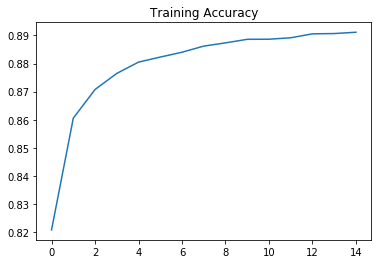

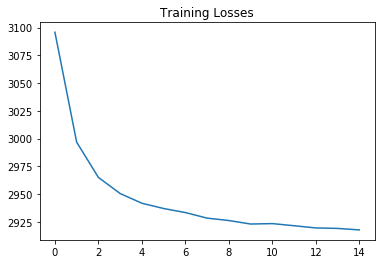

In [0]:
plt.plot(train_accuracy_list, label='')
plt.title("Training Accuracy")
plt.show()

plt.plot(running_losses_list, label='')
plt.title("Training Losses")
plt.show()

In [0]:
test_losses = []
test_accuracies = []
y_true = []
y_pred = []
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        test_losses.append(loss.item())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.flatten().tolist())
        y_pred.extend(predicted.flatten().tolist())
        
accuracy = correct / total

#test_accuracies.append(accuracy)
print('Epochs: {} \t Train Loss: {:.4f} \t Test Loss: {:.4f} \t Test Accuracy: {:.2f}'\
     .format(epoch+1, np.mean(train_losses), np.mean(test_losses), accuracy))

Epochs: 15 	 Train Loss: 1.5715 	 Test Loss: 1.5608 	 Test Accuracy: 0.89


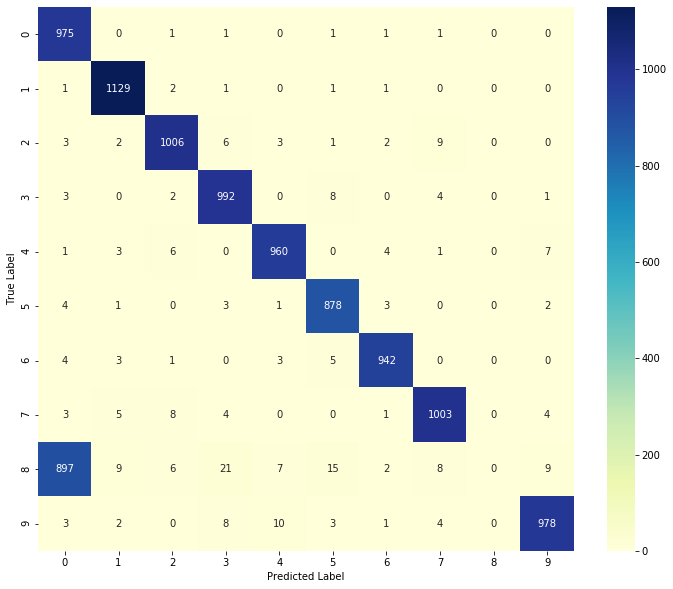

In [0]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,10))
ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.YlGnBu, fmt='d')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()